This is what we have and we continue to do this for the next deadline you will give. Hopefully it will be after the exams, and we will submit our write up in github/report page as well.


Basic idea of our project is try to do spam email detection and first by using word count to count words for spam emails and other text files.

# Pyspark exploration

## Import dataset and setup the environment 

In [1]:
from pyspark import SparkContext
import os 

# this should be JAVA_HOME path
os.environ['JAVA_HOME']="/Library/Java/JavaVirtualMachines/jdk1.8.0_202.jdk/Contents/Home/"

os.environ['PYSPARK_SUBMIT_ARGS'] = "--master local[2] pyspark-shell"

sc = SparkContext.getOrCreate()

In [26]:
data_file = "../data/labelled_dataset.csv.gz"
raw_data = sc.textFile(data_file).cache()

In [27]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("test").getOrCreate()

In [28]:
df = spark.read.csv(data_file,header=True,inferSchema=True)

## DataFrame operations

### columns name

In [7]:
df.columns

['label', 'txt']

### Select column

In [8]:
df.txt

Column<b'txt'>

### Print Schema

In [9]:
df.printSchema()

root
 |-- label: string (nullable = true)
 |-- txt: string (nullable = true)



### Head 5

In [24]:
# Didn't strictly need a for loop, could have just then head()
for row in df.head(5):
    print(row)
    print('\n')

Row(label='ham', txt='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')


Row(label='ham', txt='Ok lar... Joking wif u oni...')


Row(label='spam', txt="Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's")


Row(label='ham', txt='U dun say so early hor... U c already then say...')


Row(label='ham', txt="Nah I don't think he goes to usf, he lives around here though")




In [25]:
df.describe().show()

+-------+--------------------+------------------+
|summary|               label|               txt|
+-------+--------------------+------------------+
|  count|             1970119|            840730|
|   mean|            Infinity|1023.1263393359594|
| stddev|                 NaN|  8450.10290912209|
|    min|                   !|                  |
|    max|⸪ Great Allowance...|        ”” said he|
+-------+--------------------+------------------+



### Count

In [26]:
df.filter("label == 'spam'").count()

877

In [27]:
df.filter("label == 'books'").count()

1009

In [11]:
# https://stackoverflow.com/questions/48927271/count-number-of-words-in-a-spark-dataframe
import pyspark.sql.functions as f
data = df

### word count

In [29]:
# word count for each row
df = df.withColumn('wordCount', f.size(f.split(f.col('txt'), ' ')))
df.show()

+-----+--------------------+---------+
|label|                 txt|wordCount|
+-----+--------------------+---------+
|  ham|Go until jurong p...|       20|
|  ham|Ok lar... Joking ...|        6|
| spam|Free entry in 2 a...|       28|
|  ham|U dun say so earl...|       11|
|  ham|Nah I don't think...|       13|
| spam|FreeMsg Hey there...|       32|
|  ham|Even my brother i...|       16|
|  ham|As per your reque...|       26|
| spam|WINNER!! As a val...|       26|
| spam|Had your mobile 1...|       29|
|  ham|I'm gonna be home...|       21|
| spam|SIX chances to wi...|       26|
| spam|URGENT! You have ...|       26|
|  ham|I've been searchi...|       37|
|  ham|I HAVE A DATE ON ...|        8|
| spam|XXXMobileMovieClu...|       19|
|  ham|Oh k...i'm watchi...|        4|
|  ham|Eh u remember how...|       19|
|  ham|Fine if thatåÕs t...|       13|
| spam|England v Macedon...|       24|
+-----+--------------------+---------+
only showing top 20 rows



In [30]:
# total word
df.select(f.sum('wordCount')).collect() 

[Row(sum(wordCount)=5584925)]

In [31]:
# see what type df is
type(df)

pyspark.sql.dataframe.DataFrame

In [32]:
# first 5 row
df.take(5)

[Row(label='ham', txt='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', wordCount=20),
 Row(label='ham', txt='Ok lar... Joking wif u oni...', wordCount=6),
 Row(label='spam', txt="Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", wordCount=28),
 Row(label='ham', txt='U dun say so early hor... U c already then say...', wordCount=11),
 Row(label='ham', txt="Nah I don't think he goes to usf, he lives around here though", wordCount=13)]

In [33]:
df.show()

+-----+--------------------+---------+
|label|                 txt|wordCount|
+-----+--------------------+---------+
|  ham|Go until jurong p...|       20|
|  ham|Ok lar... Joking ...|        6|
| spam|Free entry in 2 a...|       28|
|  ham|U dun say so earl...|       11|
|  ham|Nah I don't think...|       13|
| spam|FreeMsg Hey there...|       32|
|  ham|Even my brother i...|       16|
|  ham|As per your reque...|       26|
| spam|WINNER!! As a val...|       26|
| spam|Had your mobile 1...|       29|
|  ham|I'm gonna be home...|       21|
| spam|SIX chances to wi...|       26|
| spam|URGENT! You have ...|       26|
|  ham|I've been searchi...|       37|
|  ham|I HAVE A DATE ON ...|        8|
| spam|XXXMobileMovieClu...|       19|
|  ham|Oh k...i'm watchi...|        4|
|  ham|Eh u remember how...|       19|
|  ham|Fine if thatåÕs t...|       13|
| spam|England v Macedon...|       24|
+-----+--------------------+---------+
only showing top 20 rows



### word count collection

In [14]:
df.withColumn('word', f.explode(f.split(f.col('txt'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show()

+----+------+
|word| count|
+----+------+
|    |784389|
| the|282718|
| and|194113|
|  of|163358|
|  to|145701|
|   a|103066|
|  in| 90602|
|   I| 88815|
|that| 72731|
|  he| 53735|
| his| 48351|
|  it| 46497|
|  as| 46428|
|with| 45537|
| was| 45149|
|  is| 43232|
| you| 42713|
| for| 41989|
|  my| 39440|
|  be| 37498|
+----+------+
only showing top 20 rows



In [16]:
word = df.withColumn('word', f.explode(f.split(f.col('txt'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)


In [17]:
to_list = [list(row) for row in word.collect()]

In [18]:
to_list

[['', 784389],
 ['the', 282718],
 ['and', 194113],
 ['of', 163358],
 ['to', 145701],
 ['a', 103066],
 ['in', 90602],
 ['I', 88815],
 ['that', 72731],
 ['he', 53735],
 ['his', 48351],
 ['it', 46497],
 ['as', 46428],
 ['with', 45537],
 ['was', 45149],
 ['is', 43232],
 ['you', 42713],
 ['for', 41989],
 ['my', 39440],
 ['be', 37498],
 ['not', 36717],
 ['said', 35815],
 ['but', 30960],
 ['her', 29836],
 ['by', 28872],
 ['which', 27959],
 ['had', 27774],
 ['have', 27517],
 ['at', 26732],
 ['on', 24268],
 ['all', 23451],
 ['she', 23229],
 ['or', 23213],
 ['”', 22745],
 ['they', 22602],
 ['this', 22290],
 ['from', 22200],
 ['so', 21598],
 ['me', 20026],
 ['him', 19725],
 ['are', 18955],
 ['their', 16713],
 ['your', 16205],
 ['we', 16088],
 ['no', 16000],
 ['will', 15928],
 ['an', 15740],
 ['if', 15532],
 ['who', 15366],
 ['were', 14681],
 ['when', 14664],
 ['one', 14050],
 ['what', 13680],
 ["'", 12522],
 ['them', 12275],
 ['would', 12184],
 ['been', 11145],
 ['more', 11038],
 ['there', 10798]

In [19]:
311334

311334

In [33]:
from pyspark.ml.feature import CountVectorizer

# test
# Input data: Each row is a bag of words with a ID.
dftest = spark.createDataFrame([
    (0, "a b c".split(" ")),
    (1, "a b b c a".split(" "))
], ["id", "words"])

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="features", vocabSize=3, minDF=2.0)

model = cv.fit(dftest)

result = model.transform(dftest)
result.show(truncate=False)



+---+---------------+-------------------------+
|id |words          |features                 |
+---+---------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+---+---------------+-------------------------+



In [34]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="txt", outputCol="words")

regexTokenizer = RegexTokenizer(inputCol="txt", outputCol="words", pattern="\\W")
# alternatively, pattern="\\w+", gaps(False)

countTokens = udf(lambda words: len(words), IntegerType())

tokenized = tokenizer.transform(df)

regexTokenized = regexTokenizer.transform(df)

regexTokenized.show()

+-----+--------------------+---------+--------------------+
|label|                 txt|wordCount|               words|
+-----+--------------------+---------+--------------------+
|  ham|Go until jurong p...|       20|[go, until, juron...|
|  ham|Ok lar... Joking ...|        6|[ok, lar, joking,...|
| spam|Free entry in 2 a...|       28|[free, entry, in,...|
|  ham|U dun say so earl...|       11|[u, dun, say, so,...|
|  ham|Nah I don't think...|       13|[nah, i, don, t, ...|
| spam|FreeMsg Hey there...|       32|[freemsg, hey, th...|
|  ham|Even my brother i...|       16|[even, my, brothe...|
|  ham|As per your reque...|       26|[as, per, your, r...|
| spam|WINNER!! As a val...|       26|[winner, as, a, v...|
| spam|Had your mobile 1...|       29|[had, your, mobil...|
|  ham|I'm gonna be home...|       21|[i, m, gonna, be,...|
| spam|SIX chances to wi...|       26|[six, chances, to...|
| spam|URGENT! You have ...|       26|[urgent, you, hav...|
|  ham|I've been searchi...|       37|[i

## Remove stop words

In [35]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
data = remover.transform(regexTokenized).show()

+-----+--------------------+---------+--------------------+--------------------+
|label|                 txt|wordCount|               words|            filtered|
+-----+--------------------+---------+--------------------+--------------------+
|  ham|Go until jurong p...|       20|[go, until, juron...|[go, jurong, poin...|
|  ham|Ok lar... Joking ...|        6|[ok, lar, joking,...|[ok, lar, joking,...|
| spam|Free entry in 2 a...|       28|[free, entry, in,...|[free, entry, 2, ...|
|  ham|U dun say so earl...|       11|[u, dun, say, so,...|[u, dun, say, ear...|
|  ham|Nah I don't think...|       13|[nah, i, don, t, ...|[nah, think, goes...|
| spam|FreeMsg Hey there...|       32|[freemsg, hey, th...|[freemsg, hey, da...|
|  ham|Even my brother i...|       16|[even, my, brothe...|[even, brother, l...|
|  ham|As per your reque...|       26|[as, per, your, r...|[per, request, me...|
| spam|WINNER!! As a val...|       26|[winner, as, a, v...|[winner, valued, ...|
| spam|Had your mobile 1...|

In [36]:
data = remover.transform(regexTokenized)

In [37]:
data.show()



+-----+--------------------+---------+--------------------+--------------------+
|label|                 txt|wordCount|               words|            filtered|
+-----+--------------------+---------+--------------------+--------------------+
|  ham|Go until jurong p...|       20|[go, until, juron...|[go, jurong, poin...|
|  ham|Ok lar... Joking ...|        6|[ok, lar, joking,...|[ok, lar, joking,...|
| spam|Free entry in 2 a...|       28|[free, entry, in,...|[free, entry, 2, ...|
|  ham|U dun say so earl...|       11|[u, dun, say, so,...|[u, dun, say, ear...|
|  ham|Nah I don't think...|       13|[nah, i, don, t, ...|[nah, think, goes...|
| spam|FreeMsg Hey there...|       32|[freemsg, hey, th...|[freemsg, hey, da...|
|  ham|Even my brother i...|       16|[even, my, brothe...|[even, brother, l...|
|  ham|As per your reque...|       26|[as, per, your, r...|[per, request, me...|
| spam|WINNER!! As a val...|       26|[winner, as, a, v...|[winner, valued, ...|
| spam|Had your mobile 1...|

In [39]:
# unfinished part
from pyspark.ml.feature import CountVectorizer

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="features", vocabSize=311334, minDF=2.0)

model = cv.fit(data)

result = model.transform(data)
result.show(truncate=False)

Py4JJavaError: An error occurred while calling o752.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 43.0 failed 1 times, most recent failure: Lost task 0.0 in stage 43.0 (TID 671, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$createTransformFunc$2: (string) => array<string>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:191)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.feature.RegexTokenizer$$anonfun$createTransformFunc$2.apply(Tokenizer.scala:143)
	at org.apache.spark.ml.feature.RegexTokenizer$$anonfun$createTransformFunc$2.apply(Tokenizer.scala:141)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1168)
	at org.apache.spark.ml.feature.CountVectorizer.fit(CountVectorizer.scala:230)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$createTransformFunc$2: (string) => array<string>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:191)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.feature.RegexTokenizer$$anonfun$createTransformFunc$2.apply(Tokenizer.scala:143)
	at org.apache.spark.ml.feature.RegexTokenizer$$anonfun$createTransformFunc$2.apply(Tokenizer.scala:141)
	... 18 more


## random try (skip this part)

In [135]:
df.withColumn('list', df['txt'].split(" ")).show()

TypeError: 'Column' object is not callable

In [141]:
split_col = f.split(df['txt'], ' ')

In [152]:
data = data.withColumn('NAME1', split_col.getItem(0))
data = data.withColumn('NAME2', split_col.getItem(1))



In [5]:
data.show()

NameError: name 'data' is not defined

In [116]:
df.withColumn('word', f.explode(f.split(f.col('txt'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show()

+----+------+
|word| count|
+----+------+
|    |784389|
| the|282718|
| and|194113|
|  of|163358|
|  to|145701|
|   a|103066|
|  in| 90602|
|   I| 88815|
|that| 72731|
|  he| 53735|
| his| 48351|
|  it| 46497|
|  as| 46428|
|with| 45537|
| was| 45149|
|  is| 43232|
| you| 42713|
| for| 41989|
|  my| 39440|
|  be| 37498|
+----+------+
only showing top 20 rows



In [117]:
from pyspark.ml.feature import StopWordsRemover


In [95]:
text_file = sc.textFile("../books/*.txt")


In [91]:
text_file.count()

6003218

In [7]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

sentenceDataFrame = spark.createDataFrame([
    (0, "Hi I heard about Spark"),
    (1, "I wish Java could use case classes"),
    (2, "Logistic,regression,models,are,neat")
], ["id", "sentence"])

tokenizer = Tokenizer(inputCol="sentence", outputCol="words")

regexTokenizer = RegexTokenizer(inputCol="sentence", outputCol="words", pattern="\\W")
# alternatively, pattern="\\w+", gaps(False)

countTokens = udf(lambda words: len(words), IntegerType())

tokenized = tokenizer.transform(sentenceDataFrame)
tokenized.select("sentence", "words")\
    .withColumn("tokens", countTokens(col("words"))).show(truncate=False)

regexTokenized = regexTokenizer.transform(sentenceDataFrame)
regexTokenized.select("sentence", "words") \
    .withColumn("tokens", countTokens(col("words"))).show(truncate=False)

+-----------------------------------+------------------------------------------+------+
|sentence                           |words                                     |tokens|
+-----------------------------------+------------------------------------------+------+
|Hi I heard about Spark             |[hi, i, heard, about, spark]              |5     |
|I wish Java could use case classes |[i, wish, java, could, use, case, classes]|7     |
|Logistic,regression,models,are,neat|[logistic,regression,models,are,neat]     |1     |
+-----------------------------------+------------------------------------------+------+

+-----------------------------------+------------------------------------------+------+
|sentence                           |words                                     |tokens|
+-----------------------------------+------------------------------------------+------+
|Hi I heard about Spark             |[hi, i, heard, about, spark]              |5     |
|I wish Java could use case cla

In [51]:
df = spark.createDataFrame([
    (0, "a b c".split(" ")),
    (1, "a b b c a".split(" "))
], ["id", "words"])
df.show()

+---+---------------+
| id|          words|
+---+---------------+
|  0|      [a, b, c]|
|  1|[a, b, b, c, a]|
+---+---------------+



In [16]:
from pyspark.ml.feature import CountVectorizer

# Input data: Each row is a bag of words with a ID.
df = spark.createDataFrame([
    (0, "a b c".split(" ")),
    (1, "a b b c a".split(" "))
], ["id", "words"])

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="features", vocabSize=3, minDF=2.0)

model = cv.fit(df)

result = model.transform(df)
result.show(truncate=False)

print((df.count(), len(df.columns)))


+---+---------------+-------------------------+
|id |words          |features                 |
+---+---------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+---+---------------+-------------------------+

(2, 2)


# Import different time with different size of unbalanced data

## Random data generator

In [1]:
import sys
sys.setrecursionlimit(150000)
sys.path.append('../documentation/encryption/')

from bitarray import bitarray
from MC import MarkovChain
from cryptography.fernet import Fernet

with open ("../books/3001.txt", "r", encoding="utf-8") as myfile:
    data = myfile.readlines()

m = MarkovChain()
# Learn the txt data
for i in data:
    m.learn(i)

length = 100
# Generate data with 100 words
print(m.babble(length))

 handledst pistols in the great a dryft
 enchaunted me:
 bloody staine,
 picht to him cunninglie,
 Why Mosbie my tale,
 meane to hire knaues,
 bloode we came it, hauing nought but went to be hangd vpon women, this the next encounters her,
 hir loue, without candle light,
 Perhaps I, the raylingest knaue is his time to your honest man will be slipt, til Ardens coming,
 whatsoeuer did serue me he liues.
 quitance with siluer dice:
 Me thinks me alone within,
 houes vs all.
 Tis childishnes to the Letter.
 land, weele haue you tell?
 beeing in a mist my cares he not


## Encryption and decryption part

In [2]:
# Encyption function by using Fernet
def Encrypt(data):
    # it needs a key first
    key = Fernet.generate_key()
    f = Fernet(key)
    # through the key we can do encryption and decryption as it is a symmetric algorithm
    ciphertext = f.encrypt(data)
    # return two variables key and encoded data
    return(key, ciphertext)
# Decryption
def Decrypt(key_ciphertext):
    ''' keyciphertext is a list which contains two elements
        index1: key, index2: encoded data'''
    # key = key_ciphertext[0]
    f = Fernet(key_ciphertext[0])
    # data = key_ciphertext[1]
    decrypttext = f.decrypt(key_ciphertext[1])
    return(decrypttext)

def Generator(Markov):
    return(Markov.babble(10000))

In [3]:
# An example of using Fernet to do encoding and decoding
data = Generator(m)
data = bytes(data, encoding = "utf-8")
key, ciphertext = Encrypt(data)
key_ciphertext = [key, ciphertext]
decrypttext = Decrypt(key_ciphertext)
print(decrypttext)

b" Doth challenge naught but to pick mens pockets in that I seeke to aprehend him\n Northeast wind,\n IN KENT.\n Nere longd so stout,\n content thee.\n cut him down Poules, til I list with a while, heer coms your good I haue his breast.\n answer you.\n wring me of,\n softly as securely, presently take you) that thou knowst that thou hast done, stand so soone.\n toppe bough of such a mist as I such aknaue as Greene, must go before, Ile seeke him drest,\n vyolate my grant,\n ouer kinde?\n silence such praiers as I,\n mine owne:\n blacke Will.\n ouerplus thats the sea,\n somewhat molyfied my brest.\n master of a weak to God,\n affraide, I not visit him?\n vrdged me with his fowle and now Bradshaw, Adam fowle,\n Shakebagge, canst thou thy selfe?\n howrs the Mariage of a worde,\n FEVERSHAM IN KENT.\n frend, shame scourgeth my husband.\n stifeled, that as wel deserue the more company comming after,\n Anothertime wele take no gould,\n through the Nages head, ther'is this deede.\n show some bo

In [4]:
# Run for large size of data
import time
import functools
timesaver = []
for j in range(1000,5000,1000):
    # dataset to save all the documents. (documents are both like the example above)
    dataset = []
    # generate the dataset
    data = Generator(m)
    # transfer to bytes type
    data = bytes(data, encoding = "utf-8")
    # dataset repeat data for j times to get j documents
    # if j = 1000, dataset contains 1000 documents
    # The task is to encode and decode 1000 documents 
    # ps: each document contains 10000 words
    for i in range(j):
        dataset.append(data)
    
    # start to do encryption and decrytion
    start_time = time.time()
    # encoding
    test = list(map(Encrypt,dataset))
    # decoding
    decoded = list(map(Decrypt,test))
    # count the end time and print it
    end_time = time.time() - start_time
    print(end_time)
    # save it to timesaver for visulisation
    timesaver.append(end_time)

0.8899860382080078
1.7107620239257812
2.45750093460083
3.237651824951172


In [5]:
# import time.pickle contains the timesaver for different 
import pickle
with open('../data/timedata/time.pickle', 'rb') as f:
    timesaver = pickle.load(f)

In [ ]:
# import the data generated before

In [6]:
import numpy as np
import pickle
with open('../data/timedata/time_balanced.pickle', 'rb') as f:
    # balanced data
    timesaver_b = pickle.load(f)
with open('../data/timedata/time_unbalanced.pickle', 'rb') as f:
    # unbalanced data with 50% large size and 50% small size
    timesaver_u = pickle.load(f)
with open('../data/timedata/time_unbalanced_10.pickle', 'rb') as f:
    timesaver_u10 = pickle.load(f)
with open('../data/timedata/time_unbalanced_20.pickle', 'rb') as f:
    timesaver_u20 = pickle.load(f)
with open('../data/timedata/time_unbalanced_30.pickle', 'rb') as f:
    timesaver_u30 = pickle.load(f)
with open('../data/timedata/time_unbalanced_40.pickle', 'rb') as f:
    timesaver_u40 = pickle.load(f)
with open('../data/timedata/time_unbalanced_60.pickle', 'rb') as f:
    timesaver_u60 = pickle.load(f)
with open('../data/timedata/time_unbalanced_70.pickle', 'rb') as f:
    timesaver_u70 = pickle.load(f)
with open('../data/timedata/time_unbalanced_80.pickle', 'rb') as f:
    timesaver_u80 = pickle.load(f)
with open('../data/timedata/time_unbalanced_90.pickle', 'rb') as f:
    timesaver_u90 = pickle.load(f)
with open('../data/timedata/time_unbalanced_100.pickle', 'rb') as f:
    timesaver_u100 = pickle.load(f)


## Visualisation

In [ ]:
### Fix the length of every documents,

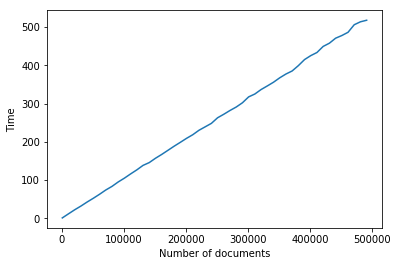

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(1000,500000,10000), timesaver)
plt.xlabel('Number of documents')
plt.ylabel('Time')
plt.show()

In [ ]:
# Maybe explain it, for example:
# with the number of documents increase the time increase linearly

In [ ]:
# unbalanced data means there contains 1000 words and 100000 words in different documents
# eg. unbalanced_10% represents:
# 10% documents have 1000 words and 90% of them have 100000 words

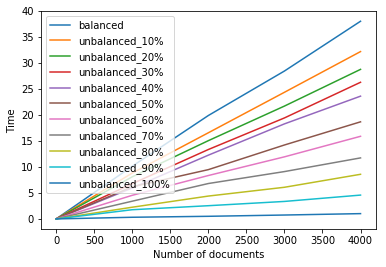

In [55]:
%matplotlib inline

plt.figure()
l2, = plt.plot(np.arange(0,5000,1000), timesaver_b)
l3, = plt.plot(np.arange(0,5000,1000), timesaver_u10)
l4, = plt.plot(np.arange(0,5000,1000), timesaver_u20)
l5, = plt.plot(np.arange(0,5000,1000), timesaver_u30)
l6, = plt.plot(np.arange(0,5000,1000), timesaver_u40)
l7, = plt.plot(np.arange(0,5000,1000), timesaver_u)
l8, = plt.plot(np.arange(0,5000,1000), timesaver_u60)
l9, = plt.plot(np.arange(0,5000,1000), timesaver_u70)
l10, = plt.plot(np.arange(0,5000,1000), timesaver_u80)
l11, = plt.plot(np.arange(0,5000,1000), timesaver_u90)
l12, = plt.plot(np.arange(0,5000,1000), timesaver_u100)

plt.xlabel('Number of documents')
plt.ylabel('Time')
plt.legend((l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12), ('balanced', 'unbalanced_10%', 'unbalanced_20%', 'unbalanced_30%', 'unbalanced_40%', 'unbalanced_50%', 'unbalanced_60%', 'unbalanced_70%', 'unbalanced_80%', 'unbalanced_90%', 'unbalanced_100%'))

# maybe it is too much lines, I chose different 
plt.show()

In [ ]:
# Analysis: Maybe this graph is not clear go to the end of the documents



TODO: Maybe we can calculate the slope or something?
TODO: Maybe can calculate if the time just depends on total words

In [ ]:
# 10000 documents (fix the number of documents)
# see how it changes with different size of documents

In [10]:
with open('../data/time_with_prob.pickle', 'rb') as f:
    timesaver_p = pickle.load(f)

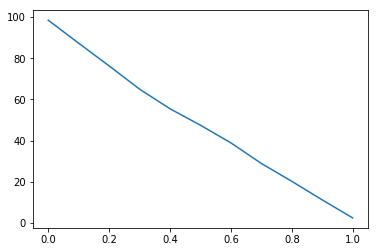

In [11]:
# from 0 to 1, use prob because I generate the data by using random variable x 
# if x < prob, it generate the documents with 1000 words, if not generate a large one
prob = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.plot(prob, timesaver_p)

In [ ]:
# basically like linear

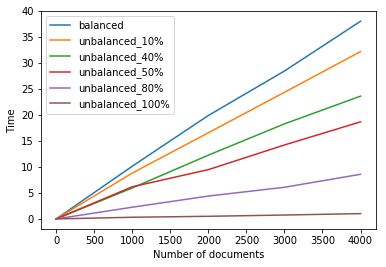

In [56]:
%matplotlib inline

plt.figure()
l2, = plt.plot(np.arange(0,5000,1000), timesaver_b)
l3, = plt.plot(np.arange(0,5000,1000), timesaver_u10)
l6, = plt.plot(np.arange(0,5000,1000), timesaver_u40)
l7, = plt.plot(np.arange(0,5000,1000), timesaver_u)
l10, = plt.plot(np.arange(0,5000,1000), timesaver_u80)
l12, = plt.plot(np.arange(0,5000,1000), timesaver_u100)

plt.xlabel('Number of documents')
plt.ylabel('Time')
plt.legend((l2, l3, l6, l7, l10, l12), ('balanced', 'unbalanced_10%', 'unbalanced_40%', 'unbalanced_50%','unbalanced_80%', 'unbalanced_100%'))

plt.show()

In [ ]:
# The 40% 50% is interesting. don't know if it is a coincidence

In [ ]:
# Just let me know what kind of graph you want: maybe can try different number of cores